# Polarization reconstruction with neutrinos

### Dec 1, 2020

## Code

In [10]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")

In [11]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Events debugging

In [26]:
appended_data = []
import os
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/Bessel/"):#Loop over desired directory
        if (filename.startswith("pol_quant_noiseless_")): #extension, .root in this case
            name = os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/Bessel/", str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)
recoNu = pd.concat(appended_data)     
# recoNu = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/debug/pol_quant_noiseless.pkl")
recoNu = recoNu.loc[recoNu.rmsV>50]
recoNu = recoNu.loc[recoNu.rmsV<1400]
recoNu = recoNu.loc[recoNu.rmsH>50]
recoNu = recoNu.loc[recoNu.rmsH<1400]
# recoNu = recoNu.loc[recoNu.theta_reco<np.pi/2+0.2]


array2 = []
R_True = []
R_Reco = []
propVec = []
dot = []
for i in recoNu.itertuples(): 
    thetaHat = np.array([np.cos(i.theta_reco)*np.cos(i.phi_reco), np.cos(i.theta_reco)*np.sin(i.phi_reco), -np.sin(i.theta_reco)])
    phiHat = np.array([-np.sin(i.phi_reco), np.cos(i.phi_reco),0])
    R_Reco.append(np.sqrt(i.powerH/i.powerV))
    R = np.dot(i.PolTrue,phiHat)/(np.dot(i.PolTrue,thetaHat))
    R_True.append(R)
    array2.append(util.PolVectorRecoPower_debug(i.powerV,i.powerH, i.theta_reco, i.phi_reco,np.sign(R)))
    propVec = np.array([np.sin(i.theta_reco)*np.cos(i.phi_reco),np.sin(i.theta_reco)*np.sin(i.phi_reco),np.cos(i.theta_reco)])
    dot.append(np.dot(propVec,i.PolTrue))
recoNu["PolReco2"] = array2
# recoNu["PolReco2"] = util.PolVectorReco(recoNu.maxV, recoNu.maxH, recoNu.theta_reco,recoNu.phi_reco)

recoNu["R_True"] = R_True
recoNu["R_Reco"] = R_Reco
recoNu["dotProd"] = dot

recoNu = recoNu.loc[abs(recoNu.dotProd)<0.001]
# recoNu = recoNu.loc[abs(recoNu.dotProd)>0.5]


Px_true = np.array([element[0] for element in recoNu.PolTrue])
Py_true = np.array([element[1] for element in recoNu.PolTrue])
Pz_true = np.array([element[2] for element in recoNu.PolTrue])

Px_reco = np.array([element[0] for element in recoNu.PolReco2])
Py_reco = np.array([element[1] for element in recoNu.PolReco2])
Pz_reco = np.array([element[2] for element in recoNu.PolReco2])


thetaPol_true = np.degrees(np.arccos(abs(Pz_true)))
thetaPol_reco = np.degrees(np.arccos(abs(Pz_reco)))
phiPol_true = np.degrees(np.arctan2(abs(Py_true),abs(Px_true)))
phiPol_reco = np.degrees(np.arctan2(abs(Py_reco),abs(Px_reco)))

recoNu["delta"] = thetaPol_reco-thetaPol_true
recoNu["deltaPhi"] = phiPol_reco-phiPol_true



delta = thetaPol_reco-thetaPol_true
deltaPhi = phiPol_reco-phiPol_true

# delta = delta[~np.isnan(delta)]

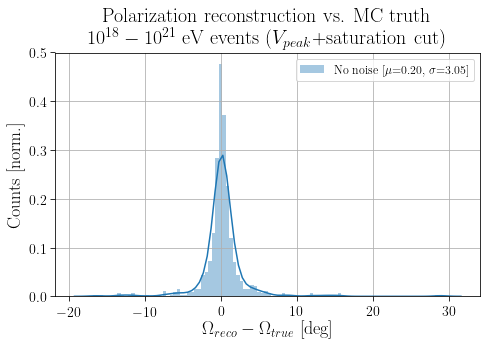

In [27]:
plt.figure(figsize=(7,5))
# plt.hist(recoNu.AngStokes-np.degrees(np.arccos(abs(recoNu.pol_z))), bins=100, density=False, alpha=1);
delta_std = (delta).std()
delta_mean = (delta).mean()
sns.distplot((delta), bins=100,label = "No noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\Omega_{reco}-\Omega_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events ($V_{peak}$+saturation cut)")

# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_Cuts_noAbs.png', dpi=150)


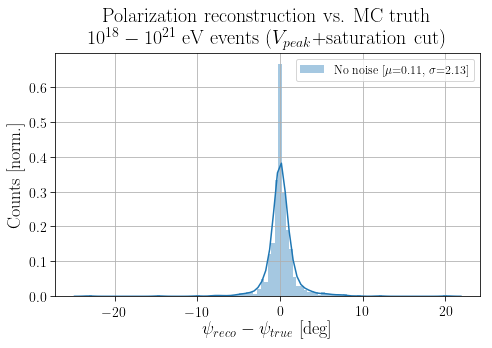

In [28]:
plt.figure(figsize=(7,5))
# plt.hist(recoNu.AngStokes-np.degrees(np.arccos(abs(recoNu.pol_z))), bins=100, density=False, alpha=1);
delta_std = (deltaPhi).std()
delta_mean = (deltaPhi).mean()
sns.distplot((deltaPhi), bins=100,label = "No noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\psi_{reco}-\psi_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events ($V_{peak}$+saturation cut)")

# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_Cuts.png', dpi=150)


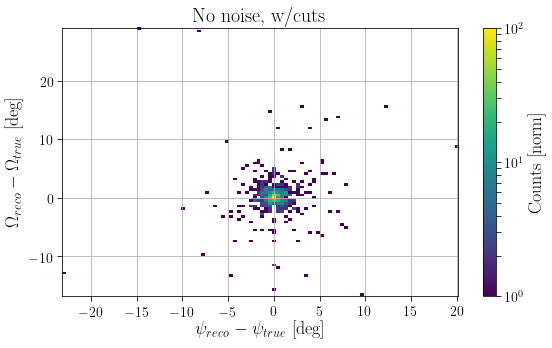

In [29]:
plt.figure(figsize=(8,5))
plt.hist2d(deltaPhi,delta, bins=100, normed=False,norm=mpl.colors.LogNorm());
# plt.hist2d(90-recoNu_noise.AngStokes,recoNu_noise.AngStokes-recoNu_noise.theta_pol, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [norm]")
plt.ylabel("$\Omega_{reco}-\Omega_{true}$ [deg]")
plt.xlabel("$\psi_{reco}-\psi_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()
# plt.xlim(0,90)
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_Cuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsReco_AraSim_noiseless_noCuts.png', dpi=150)

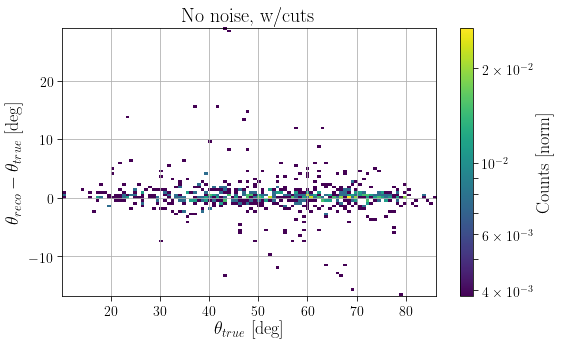

In [19]:
plt.figure(figsize=(8,5))
plt.hist2d(thetaPol_true,delta, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.hist2d(90-recoNu_noise.AngStokes,recoNu_noise.AngStokes-recoNu_noise.theta_pol, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$ [deg]")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()
# plt.xlim(0,90)
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_Cuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsReco_AraSim_noiseless_noCuts.png', dpi=150)

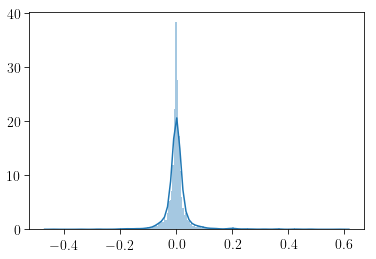

In [8]:
sns.distplot(abs(Pz_true)-abs(Pz_reco), bins = 200);

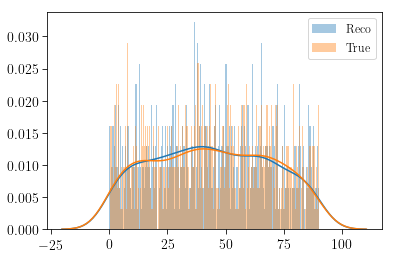

In [25]:
# Pz_true = Pz_true[Pz_true<0]
sns.distplot(phiPol_reco, bins=200, label = "Reco");
sns.distplot(phiPol_true, bins=200, label = "True");
plt.legend()

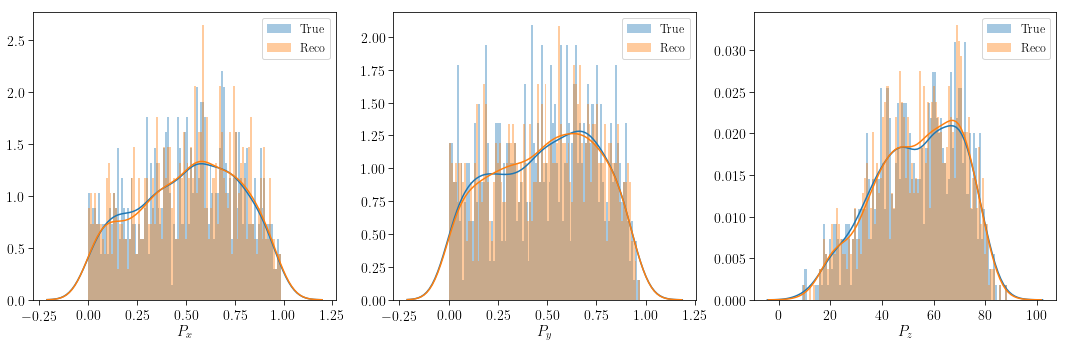

In [26]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
f, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(abs(Px_true), bins=100, label= "True", ax=axes[0]);
sns.distplot(abs(Px_reco), bins=100, label= "Reco", ax=axes[0]);
axes[0].set_xlabel("$P_x$", fontsize=15)
# sns.legend()
axes[0].legend()

sns.distplot(abs(Py_true), bins=100, label= "True", ax=axes[1]);
sns.distplot(abs(Py_reco), bins=100, label= "Reco", ax=axes[1]);
axes[1].set_xlabel("$P_y$", fontsize=15)
# sns.legend()
axes[1].legend()

sns.distplot(np.degrees(np.arccos(abs(Pz_true))), bins=100, label= "True", ax=axes[2]);
sns.distplot(np.degrees(np.arccos((Pz_reco))), bins=100,label= "Reco", ax=axes[2]);
axes[2].set_xlabel("$P_z$", fontsize=15)
axes[2].legend()

plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_PxPyPz.png', dpi=150)


### Make function to write input files

In [105]:
def makeInputFile(posnu_x, posnu_y, posnu_z, nnu_x, nnu_y, nnu_z, nuflavorint, nu_nubar, pnu, currentint, elast_y):
    """
    Make input file to be read by AraSim (only works if using A2). It's very rudimentary, but it works.
    Author: Jorge Torres, Dec 3.
    Parameters
    ----------
    All the inputs are given in AraSim output coordinates/units.
    Returns
    -------
    Prints something that can be copied and pasted as an input file.
    """
    #posnu
    posNu = np.array([posnu_x, posnu_y, posnu_z])
    avgVec = np.array([10000.83568, 9998.89765, 6359452.44702])
    posNu2 = posNu-avgVec #AraSim adds avgVec when transforming coordinates, and this is what AraSim outputs
    norm = np.linalg.norm(posNu2)
    posNu2 = posNu2/norm#Normalize
    posnu_r = norm
    
    posnu_theta = np.pi/2-np.arccos(posNu2[2])
    posnu_phi = np.arctan2(posNu2[1],posNu2[0])+2*np.pi

    #nnu
    nnu = np.array([nnu_x, nnu_y, nnu_z])
    nnu_phi = np.arctan2(nnu[1],nnu[0])+2*np.pi
    nnu_theta = np.arccos(nnu[2])
    print("//VERSION=0.1\n//EVENT_NUM=" + str(1) + 
          "\n//evid nuflavorint nu_nubar pnu currentint posnu_r posnu_theta posnu_phi nnu_theta nnu_phi elast_y")
    print("{:08d} {:01d} {:01d} {:.3f} {:01d} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}\n".format(1, 
        int(nuflavorint), int(nu_nubar), pnu, int(currentint), posnu_r, posnu_theta, posnu_phi, nnu_theta, nnu_phi, elast_y))

In [106]:
makeInputFile(13241.106738257564, 7344.90784362127, 6357052.9861091385 ,-0.7686674988346609, 0.5288005856931569, -0.3598891729488969,2,0,21,0,0.338077)

//VERSION=0.1
//EVENT_NUM=1
//evid nuflavorint nu_nubar pnu currentint posnu_r posnu_theta posnu_phi nnu_theta nnu_phi elast_y
00000001 2 0 21.000 0 4827.0520 -0.5202 5.5969 1.9389 8.8222 0.3381



## Continue debuging pol. reco

In [34]:
Antenna = np.array([10004.4,9989.17,6.35944e+06])
posNu = np.array([13241.10, 7344.76, 6357053.14])
avgVec = np.array([10000.83568, 9998.89765, 6359452.44702])
norm = np.linalg.norm(avgVec)
avgVec_norm = avgVec/norm
new_Ant = (Antenna-avgVec)/np.linalg.norm(Antenna-avgVec)
new_Ant
AntennaNorm = Antenna/np.linalg.norm(Antenna)

#### Dot product

In [33]:
theta = np.radians(123.49) #2.15534
phi = 2.456308762722442
dirProp = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
AraSim_dirProp = np.array([-0.6474, 0.5260, -0.5516])
polVec = np.array([-0.367996,0.418120,0.830515])

In [477]:
np.dot(polVec,dirProp)

3.727978183376557e-05

In [457]:
#What AraSim does for theta
np.arccos(np.dot(AraSim_dirProp,AntennaNorm))

2.1553064231591708

In [448]:
#What AraSim does for phi
proj = np.cross(np.cross(AntennaNorm,dirProp),AntennaNorm)
np.degrees(np.arctan2(proj[1],proj[0]))

140.65223864038154

In [429]:
AraSim_dirProp

array([-0.6474,  0.526 , -0.5516])

In [397]:
dirProp

array([-0.64647382,  0.52687552, -0.55179144])

Put prop. vector in the antenna coord. system

In [398]:
prop_Antenna = (AraSim_dirProp-AntennaNorm)/np.linalg.norm(AraSim_dirProp-AntennaNorm)
polVec2 = (polVec-AntennaNorm+avgVec_norm)/np.linalg.norm(polVec-AntennaNorm+avgVec_norm)

In [399]:
np.dot(prop_Antenna,polVec)

-0.471432758141536

In [400]:
# np.arctan2(prop_Antenna[1],prop_Antenna[0])
(np.arccos(prop_Antenna[2])-np.pi/2)

1.0774018547041502

In [41]:
(polVec-avgVec_norm)/np.linalg.norm(polVec-avgVec_norm)

array([-0.63491017,  0.71561921, -0.29116701])

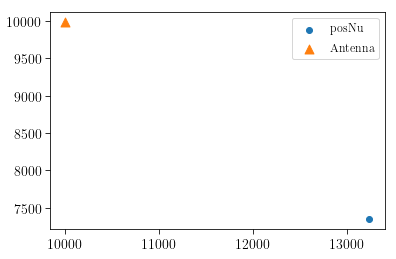

In [484]:
plt.scatter(posNu[0],posNu[1],label="posNu")
plt.scatter(Antenna[0],Antenna[1],marker = "^",s=80, label="Antenna")
plt.legend()